interactive(children=(Dropdown(description='Geounit:', options=('APG', 'ECP', 'NAO', 'QTG'), value='APG'), Out…

Total Revenue Comparison Across All Geounits (from Oct 2022):
  Geounit  Tickets Revenue   RPE Revenue   Difference  Difference %
0     APG     3.893752e+07  3.926929e+07    331761.79      0.852036
3     QTG     7.986976e+07  7.947786e+07   -391906.27     -0.490682
1     ECP     5.469035e+07  5.289510e+07  -1795241.69     -3.282557
2     NAO     1.239759e+08  1.126130e+08 -11362885.06     -9.165397


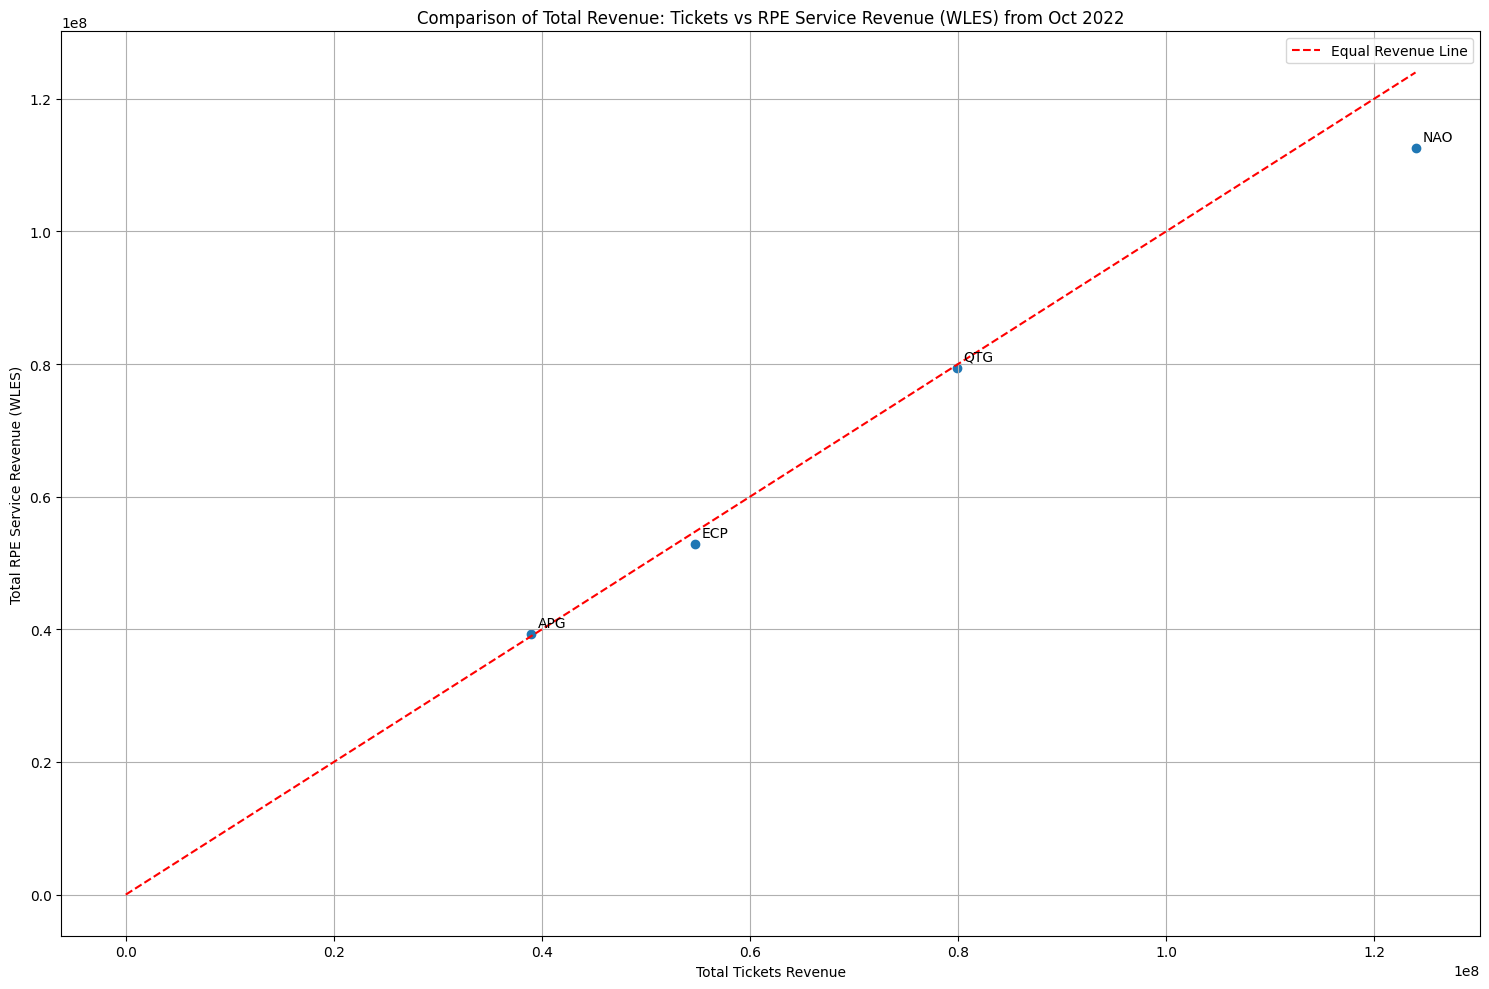


Overall Correlation between Tickets and RPE Service Revenue: 0.6699


In [1]:
# 03_compare_revenue_sources.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import ipywidgets as widgets
from ipywidgets import interact
import importlib
import utils.revenue_data_preprocessing as rdp

# Reload the module to ensure we have the latest version
importlib.reload(rdp)

# Load and preprocess the data
tickets_df = pd.read_csv('../raw_data/global_tickets_wles_ops_data.csv')
rpe_revenue_df = pd.read_csv('../raw_data/global_rpe_revenue.csv')

tickets_df = rdp.preprocess_tickets_data(tickets_df)
rpe_revenue_df = rdp.preprocess_rpe_data(rpe_revenue_df)  # This now includes only WLES data

# Prepare monthly revenue data for tickets
tickets_monthly = tickets_df.groupby(['Sl Geounit (Code)', pd.Grouper(key='Adjusted Date', freq='MS')])['Field Ticket USD net value'].sum().reset_index()
tickets_monthly.columns = ['Geounit', 'Date', 'Tickets Revenue']

# Prepare monthly revenue data for RPE (WLES only)
rpe_monthly = rpe_revenue_df.groupby(['SL Geounit (Code)', pd.Grouper(key='Month Date', freq='MS')])['RPE Revenue'].sum().reset_index()
rpe_monthly.columns = ['Geounit', 'Date', 'RPE Revenue']

# Merge the two datasets
merged_data = pd.merge(tickets_monthly, rpe_monthly, on=['Geounit', 'Date'], how='outer').fillna(0)

# Filter data from October 2022 onwards
start_date = pd.to_datetime('2022-10-01')
merged_data = merged_data[merged_data['Date'] >= start_date]

# Get unique geounits
geounits = sorted(merged_data['Geounit'].unique())

# Create the plotting function
def plot_revenue_comparison(geounit):
    data = merged_data[merged_data['Geounit'] == geounit]
    
    plt.figure(figsize=(15, 8))
    plt.plot(data['Date'], data['Tickets Revenue'], label='Tickets Revenue')
    plt.plot(data['Date'], data['RPE Revenue'], label='RPE Service Revenue (WLES)')
    
    plt.title(f'Monthly Revenue Comparison for Geounit: {geounit} (from Oct 2022)')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for {geounit} (from Oct 2022):")
    print(data[['Tickets Revenue', 'RPE Revenue']].describe())
    
    # Calculate and print total revenue from each source
    total_tickets = data['Tickets Revenue'].sum()
    total_rpe = data['RPE Revenue'].sum()
    print(f"\nTotal Tickets Revenue: ${total_tickets:,.2f}")
    print(f"Total RPE Service Revenue (WLES): ${total_rpe:,.2f}")
    print(f"Difference (RPE WLES Service Revenue - Tickets): ${total_rpe - total_tickets:,.2f}")
    
    # Calculate and print correlation
    correlation = data['Tickets Revenue'].corr(data['RPE Revenue'])
    print(f"\nCorrelation between Tickets and RPE Service Revenue: {correlation:.4f}")
    
# Create the interactive widget
interact(plot_revenue_comparison, geounit=widgets.Dropdown(options=geounits, description='Geounit:'))

# Function to compare total revenue across all geounits
def compare_total_revenue():
    total_comparison = merged_data.groupby('Geounit').agg({
        'Tickets Revenue': 'sum',
        'RPE Revenue': 'sum'
    }).reset_index()
    
    total_comparison['Difference'] = total_comparison['RPE Revenue'] - total_comparison['Tickets Revenue']
    total_comparison['Difference %'] = (total_comparison['Difference'] / total_comparison['Tickets Revenue']) * 100
    total_comparison = total_comparison.sort_values('Difference', ascending=False)
    
    print("Total Revenue Comparison Across All Geounits (from Oct 2022):")
    print(total_comparison)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    plt.scatter(total_comparison['Tickets Revenue'], total_comparison['RPE Revenue'])
    
    for i, row in total_comparison.iterrows():
        plt.annotate(row['Geounit'], 
                     (row['Tickets Revenue'], row['RPE Revenue']),
                     xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Total Tickets Revenue')
    plt.ylabel('Total RPE Service Revenue (WLES)')
    plt.title('Comparison of Total Revenue: Tickets vs RPE Service Revenue (WLES) from Oct 2022')
    
    
    max_val = max(total_comparison['Tickets Revenue'].max(), total_comparison['RPE Revenue'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Equal Revenue Line')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate overall correlation
    overall_correlation = merged_data['Tickets Revenue'].corr(merged_data['RPE Revenue'])
    print(f"\nOverall Correlation between Tickets and RPE Service Revenue: {overall_correlation:.4f}")

# Run the total revenue comparison
compare_total_revenue()

In [2]:
import pandas as pd
import re

# Assuming tickets_df and rpe_revenue_df are already loaded and preprocessed

# Extract unique ticket numbers/IDs from both datasets
rpe_ticket_numbers = set(rpe_revenue_df['Field Ticket Number'].dropna().unique())
tickets_ids = set(tickets_df['Field Ticket ID'].dropna().unique())

# Function to extract the base ticket number (before the second dot)
def extract_base_ticket(ticket):
    parts = str(ticket).split('.')
    return '.'.join(parts[:2]) if len(parts) > 1 else ticket

# Create dictionaries with base ticket numbers as keys
rpe_base_tickets = {extract_base_ticket(tn): tn for tn in rpe_ticket_numbers}
tickets_base_ids = {extract_base_ticket(tid): tid for tid in tickets_ids}

# Find ticket numbers in RPE data that don't exist in tickets data
rpe_not_in_tickets = [tn for base, tn in rpe_base_tickets.items() if base not in tickets_base_ids]

# Find ticket IDs in tickets data that don't exist in RPE data
tickets_not_in_rpe = [tid for base, tid in tickets_base_ids.items() if base not in rpe_base_tickets]

# Print results
print("Ticket numbers in RPE data that don't exist in tickets data:")
print(rpe_not_in_tickets[:10])  # Print first 10 for brevity
print(f"Total count: {len(rpe_not_in_tickets)}")

print("\nTicket IDs in tickets data that don't exist in RPE data:")
print(tickets_not_in_rpe[:10])  # Print first 10 for brevity
print(f"Total count: {len(tickets_not_in_rpe)}")

# Optional: Save results to CSV files for further analysis
pd.Series(rpe_not_in_tickets).to_csv('../results/rpe_tickets_not_in_field_data.csv', index=False)
pd.Series(tickets_not_in_rpe).to_csv('../results/field_tickets_not_in_rpe_data.csv', index=False)

# Verification step
print("\nVerification:")
test_rpe_ticket = "1050836.S5V13"
test_field_ticket = "1050836.S5V9.9FC0EF33"
print(f"RPE ticket {test_rpe_ticket} base: {extract_base_ticket(test_rpe_ticket)}")
print(f"Field ticket {test_field_ticket} base: {extract_base_ticket(test_field_ticket)}")
print(f"RPE ticket {test_rpe_ticket} {'matches' if extract_base_ticket(test_rpe_ticket) == extract_base_ticket(test_field_ticket) else 'does not match'} field ticket {test_field_ticket}")

# Additional verification with more examples
print("\nAdditional Verifications:")
test_cases = [
    ("1234567.ABC12", "1234567.ABC12.XYZ789"),
    ("9876543.DEF45", "9876543.DEF45.123456"),
    ("1122334.GHI67.extra", "1122334.GHI67.something_else")
]

for rpe, field in test_cases:
    print(f"RPE: {rpe}, Field: {field}, Match: {extract_base_ticket(rpe) == extract_base_ticket(field)}")

Ticket numbers in RPE data that don't exist in tickets data:
['1021046.Z4C44', '1014562.S2D3', '1018746.N6P48', '1030987.P0K16', '1015797.C2Q61', '1047951.S2D24', '1014562.C2Q10', '1035893.R5E9', '1029642.M8D14', '1019718.Q1X2']
Total count: 284

Ticket IDs in tickets data that don't exist in RPE data:
['1027604.4O2.61591F95', '1001639.R7P362.D6A5EABA', '1041315.R7P21.5C00F3E9', '1001639.R7P320.3D8B32BF', '1029651.X4O2.A3EC1F87', '1010585.4Z20.F076C085', '1001693.A0Y26.47D4B560', '1001688.A0Y69.EE3CC76E', '1001556.L6I78.304EAED7', '1024839.A0N38.F13B1690']
Total count: 651

Verification:
RPE ticket 1050836.S5V13 base: 1050836.S5V13
Field ticket 1050836.S5V9.9FC0EF33 base: 1050836.S5V9
RPE ticket 1050836.S5V13 does not match field ticket 1050836.S5V9.9FC0EF33

Additional Verifications:
RPE: 1234567.ABC12, Field: 1234567.ABC12.XYZ789, Match: True
RPE: 9876543.DEF45, Field: 9876543.DEF45.123456, Match: True
RPE: 1122334.GHI67.extra, Field: 1122334.GHI67.something_else, Match: True
